# Run in Colab to load libraries and data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
BASE_DIR = '/content/drive/My\ Drive/Pig_Vision/'
import os
from shutil import unpack_archive

ImageDatasetFile = os.path.join(BASE_DIR,'pig_vision','ImageDataset.py')
!cp $ImageDatasetFile .

local_data_dir = 'data'
if not os.path.exists(local_data_dir): os.mkdir(local_data_dir)
cur_data = 'subsampled'
data_tar = os.path.join(BASE_DIR, 'data', cur_data + '.tar')
print(data_tar)
!cp $data_tar data/


unpack_archive(os.path.join(local_data_dir,cur_data + '.tar'), extract_dir=os.path.join(local_data_dir,cur_data), format='tar')

!ls data

DIR = local_data_dir

Function Definitions
----------------------

log functions, then visualisation, then train and test model


In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
plt.ion()   # interactive mode
%matplotlib inline
import time
import os
import datetime
import copy
import scipy
import sklearn.metrics
import ImageDataset
import log_util

try:
    DIR
except NameError:
    DIR = os.path.join(os.path.dirname( os.getcwd() ),'data')
    cur_data = 'subsampled'
    print(DIR)

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((100,150), scale = [0.8,1]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.RandomResizedCrop((100,150), scale = [0.8,1]),
        transforms.ToTensor()
    ]),
}


SAVE_DIR = os.path.join(os.path.dirname( DIR ),'logs')
log = log_util.Log(save_folder=SAVE_DIR,log_file='log.txt',debug=True)
data_dir = os.path.join(DIR, cur_data)
detect_laying = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

log.out('current data folder:',cur_data)
log.out('detecting_laying:',detect_laying)


D:\GoogleDrive2\Pig_Vision\data
GeForce RTX 2070 SUPER
current data folder: subsampled
detecting_laying: True


In [2]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
        
def visualize_smoothing(y_true,y_pred_first_val,y_pred_consensus):
    t = np.array(range(0,len(y_true)*5,5))/3600
    plt.figure(figsize=(9, 3))
    plt.subplot(311)
    plt.plot(t, y_true)
    plt.subplot(312)
    plt.plot(t, y_pred_first_val)
    plt.subplot(313)
    plt.plot(t, y_pred_consensus)
    plt.suptitle('Smoothing')

def consensus_vote(cur_vote,x):
    if cur_vote == 0 and sum(x) == len(x):
        return 1
    if cur_vote == 1 and sum(x) == 0:
        return 0
    return cur_vote


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    start_train_time = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        log.out('Epoch {}/{}'.format(epoch, num_epochs - 1))
        log.out('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            log.out('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        log.out()

    log.print_time(start_train_time,'Training')
    log.out('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def test_model(model,dataloader):
    dataset_size = len(dataloader)//2
    y_pred_first_val = np.zeros((dataset_size,1))
    y_pred_majority = np.zeros((dataset_size,1))
    y_pred_consensus = np.zeros((dataset_size,1))
    y_true = np.zeros((dataset_size,1))
    i = 0
    cur_vote = 0
    model.eval() 
    for inputs,labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        prediction = torch.argmax(model(inputs),dim=1)
        prediction = prediction.cpu().data.numpy().reshape([-1,1])
        labels = labels.cpu().data.numpy().reshape([-1,1])
        cur_vote = consensus_vote(cur_vote,prediction)
        y_pred_consensus[i] = cur_vote
        y_pred_majority[i] = scipy.stats.mode(prediction)[0][0][0]
        y_pred_first_val[i] = prediction[0]
        y_true[i] = labels[0]
        i+=1
        if i >= dataset_size:
            break
    return y_true,y_pred_first_val,y_pred_majority,y_pred_consensus

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

data loaded with classes: ['not_laying', 'laying']


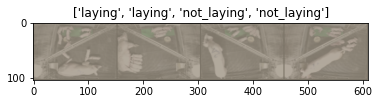

In [6]:
image_datasets = {x: ImageDataset.TrainImageFolder(os.path.join(data_dir, x), detect_laying,transform=data_transforms[x])
                  for x in ['train', 'val']}

#use weighted sampling to balance data sets
samplers = {x:torch.utils.data.sampler.WeightedRandomSampler(torch.DoubleTensor(image_datasets[x].weights), len(image_datasets[x].weights))
           for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=False, sampler=samplers[x],num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
log.out('data loaded with classes:',class_names)

# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Load the Pre-trained Model and Tranfer
----------------------

set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>__.

In [7]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
n_epochs = 1
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=n_epochs)

log.out('saving model after',n_epochs)
#save model:
model_path = os.path.join(log.LOG_DIR, 'model.pth')
torch.save(model_conv, model_path)


#log.print_time(intro='train time:',stime=start_time)

log.out('validating model with balanced data...')
y_true, y_pred, _, _  = test_model(model_conv,dataloaders['val'])

        
    #disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
    #    disp.plot()
    #    plt.show()
f1 = sklearn.metrics.f1_score(y_true, y_pred, average='macro')

log.out('f1 score (no vote, as data is not in order):',f1)

cm = sklearn.metrics.confusion_matrix(y_true,y_pred,normalize='None')
log.printTable(cm,header='Confusion Matrix', col_names=image_datasets['val'].classes)
cm = sklearn.metrics.confusion_matrix(y_true,y_pred,normalize='row')
log.printTable(cm)



Epoch 0/0
----------
train Loss: 0.4198 Acc: 0.8332
val Loss: 0.2282 Acc: 0.9062

---- Training run time: 0 hours, 2 minutes, 11 seconds ----
Best val Acc: 0.906202
saving model after 1
validating model with balanced data...
f1 score (no vote, as data is not in order): 0.9052052909355761
+========+========+
| 42.97% |  3.24% |
+--------+--------+
|  6.22% | 47.57% |
+--------+--------+


Test and Visualize Model
---------

first on balanced test set, then with a whole day

In [9]:
log.printTable(cm,header=image_datasets['val'].classes, col_names=image_datasets['val'].classes)
#visualize_model(model_conv)
#plt.ioff()
#plt.show()

+------------++--------+--------+
|            || not_laying | laying |
+============++========+========+
| not_laying || 42.97% |  3.24% |
+------------++--------+--------+
|     laying ||  6.22% | 47.57% |
+------------++--------+--------+
